# Justin's Workbook for Zillow Clustering Exploration

In [3]:
#imports
import pandas as pd
import numpy as np
import acquire
import prepare
import explore
from env import host, user, password

#Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn Tools and Modules
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

In [ ]:
#Acquire Data using acquire module and get_zillow_data function
df = acquire.get_zillow_data(cached=True)

#Return the shape of the dataframe
df.shape

In [ ]:
len(df.parcelid.unique())

In [ ]:
df.fips.isna().sum()

In [ ]:
df.fips.dropna(axis=0,inplace=True)

In [ ]:
df.fips.value_counts()

In [ ]:
df.head()

## Data Preparation

In [ ]:
df = prepare.wrangle_zillow()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.head(1)

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.fips.unique()

## Data Exploration

### Check for Outliers

In [ ]:
def outlier_label(x, lower, upper):
    if (lower >= x) or (x >= upper):
        return 1
    else:
        return 0

In [ ]:
columns_to_check = ['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror', 'age', 'taxrate', 'acres']

for col in columns_to_check:
    quartile_01, quartile_03 = np.percentile(df[col], [25, 75])
    iqr = quartile_03 - quartile_01
    
    lower_bound = quartile_01 -(3 * iqr)
    upper_bound = quartile_03 +(3 * iqr)
    
    df['is_outlier'] = df[col].apply(lambda x: outlier_label(x, lower_bound, upper_bound))
    

    print(f"The lower and upper bound of the range for '{col}' respectively is: {lower_bound} and {upper_bound}")

In [ ]:
df.columns

In [ ]:
outliers = df['is_outlier'] == 1 # filter for outliers
df[outliers][['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror', 'age', 'taxrate', 'acres']].groupby('parcelid').head()

In [ ]:
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [ ]:
df.is_outlier.value_counts()

### Separate Counties in Individual Dataframes

In [ ]:
#Create LA County Dataframe
df_la = df[df.LA == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_la.shape

In [ ]:
#Create Ventura County df
df_vent = df[df.Ventura == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_vent.shape

In [ ]:
#Create Orange County df
df_orange = df[df.Orange == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_orange.shape

#### Starting with Analysis for LA County Props

In [ ]:
partitions = explore.split(df_la, target_var='logerror')

In [ ]:
train = partitions[0]

In [ ]:
#Separate logerror into quantiles
train['logerror_class'] = pd.qcut(train.logerror, q=4, labels=['q1', 'q2', 'q3', 'q4'])

In [ ]:
train.columns

In [ ]:
categorical_target = 'logerror_class'
continuous_target = 'logerror'
binary_vars = ['hot_month_sale', 'has_heat','is_outlier', 'cola']
quant_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

#### Univariate Exploration

In [ ]:
explore.explore_univariate(train, binary_vars, quant_vars)

**Univariate Takeaways:**
- 47% of properties were last sold between the 4 month period of May - August (Q2) ==> Definitely the 'hot months' for real estate sales <br>

- Most properties have heat (99%) in LA County

- Haven't removed outliers yet...by the IQR definition with a multiplier of 3, 13% of observations in LA County have an outlier in at least one feature
    - Max bathroom count is 13

- Only 36% of properties in LA County are in the City of Los Angeles

- Buiding Quality Type is not normally distributed...what kind of dist is that?

- Latitude: Most of the properties are below 34.18 latitude. Is COLA lat coordinates above 34.18?

- Longitude is more normally distributed...geographically this seems to make sense to me

- Error in zip code... check property with zip of 399675

- Drop roocnt

- STD for land value and sturcture value is similar

- Tax rate of 49%!??!

- 160 acres!?!?!?


In [ ]:
explore.explore_bivariate(train, categorical_target, continuous_target, binary_vars, quant_vars)

**Multivariate Takeaways:**
- Latitude vs Logerror: There is a latitude (>34.3) where log error is more centered around 0
    - Runs stats test for this
- As structuretaxvaluedollarcnt increases, logerror is more centered around 0

#### GEOPY SECTION - IN PROGRESS AND DEBUGGING (WORKING TO VALIDATE INVALID ZIPCODES)

In [ ]:
#wrong_zip = train[train.regionidzip == train.regionidzip.max()]

In [ ]:
#wrong_zip

In [ ]:
#from geopy.geocoders import Nominatim
#import geopy

In [ ]:
#geolocator = Nominatim(user_agent="jjjjjjjjjj")

In [ ]:
#location = geolocator.reverse('34.154731, -117.954681')
#print(location.address)

In [ ]:
#location = geolocator.reverse('34.144255, -117.969104')
#print(location.address)

In [ ]:
#wrong_zip['latitude'] = wrong_zip['latitude'].astype(str)

In [ ]:
#wrong_zip['longitude'] = wrong_zip['longitude'].astype(str)

In [ ]:
#wrong_zip['prop_coordinates'] = wrong_zip[['latitude', 'longitude']].apply(lambda x : '{},{}'.format(x[0],x[1]), axis=1)

In [ ]:
#location = geolocator.reverse('34.145644,-117.954984')
#print(location.address)

In [ ]:
#def get_adress(df):
#    for x in df['prop_coordinates']:
#        location = geolocator.reverse(f'{x}')
#        return location.address
#    

In [ ]:
#for x in wrong_zip:
#    df['prop_address'] = wrong_zip['prop_coordinates'].apply(lambda x: get_adress(wrong_zip))

In [ ]:
#wrong_zip

# Explore using wrangle_zillow second 

In [4]:
#Acquire Data using acquire module and get_zillow_data function
df = acquire.get_zillow_data(cached=True)

#Return the shape of the dataframe
df.shape

(77413, 67)

In [5]:
#Prepare the data using wrangle zillow 2
df = prepare.wrangle_zillow_2nd()
df.shape

(69305, 21)

## Separate into three frames by county

In [6]:
#Create LA County Dataframe
df_la = df[df.LA == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_la.shape

(43768, 18)

In [7]:
#Create Ventura County df
df_vent = df[df.Ventura == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_vent.shape

(5695, 18)

In [8]:
#Create Orange County df
df_orange = df[df.Orange == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 
df_orange.shape

(19842, 18)

In [9]:
df.sample(20)

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,...,logerror,LA,Orange,Ventura,age,taxrate,acres,cola,hot_month_sale,has_heat
parcelid,,,,,,,,,,,,,,,,,,,,,
12599206,3.0,3.0,8.0,1837.0,33.823687,-118.316329,6.037651e+07,54722.0,96159.0,197585.0,...,-0.031880,1,0,0,26.0,1.140124,0.142424,0,1,1
10719918,2.0,3.0,6.0,1410.0,34.206189,-118.614108,6.037134e+07,12447.0,96342.0,44091.0,...,-0.020962,1,0,0,55.0,1.406558,0.175895,1,1,1
17090051,3.0,5.0,6.0,2419.0,34.298868,-119.166405,6.111001e+07,34543.0,97084.0,69148.0,...,-0.053613,0,0,1,53.0,1.100799,0.160698,0,0,0
12808080,2.0,3.0,4.0,1124.0,34.046934,-117.981661,6.037407e+07,39306.0,96490.0,75000.0,...,0.042439,1,0,0,62.0,1.316844,0.178444,0,0,1
12679985,2.0,3.0,6.0,1158.0,33.818915,-118.354880,6.037651e+07,54722.0,96163.0,27105.0,...,-0.024385,1,0,0,62.0,1.288480,0.121051,0,1,1
11672128,4.0,4.0,9.0,3502.0,34.075992,-118.551730,6.037263e+07,12447.0,96120.0,418573.0,...,0.119645,1,0,0,23.0,1.219071,0.133425,1,0,1
14727731,2.5,3.0,6.0,1578.0,33.671416,-117.817065,6.059053e+07,52650.0,96948.0,140379.0,...,-0.061129,0,1,0,34.0,1.052216,0.167883,0,0,0
14405632,1.5,2.0,6.0,1187.0,33.516845,-117.664564,6.059042e+07,33840.0,96985.0,67332.0,...,0.001587,0,1,0,52.0,1.052960,0.034412,0,1,0
12485159,2.0,3.0,4.0,1549.0,33.857112,-118.112980,6.037571e+07,12292.0,96213.0,101159.0,...,-0.113134,1,0,0,61.0,1.246473,0.130119,0,1,1


**Analyze By LA County without outliers**

In [10]:
partitions = explore.split(df_la, target_var='logerror')

In [11]:
train = partitions[0]

In [12]:
#Separate logerror into quantiles
train['logerror_class'] = pd.qcut(train.logerror, q=4, labels=['q1', 'q2', 'q3', 'q4'])

In [13]:
train.columns

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror',
       'age', 'taxrate', 'acres', 'cola', 'hot_month_sale', 'has_heat',
       'logerror_class'],
      dtype='object')

In [14]:
categorical_target = 'logerror_class'
continuous_target = 'logerror'
binary_vars = ['hot_month_sale', 'has_heat', 'cola']
quant_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

### Univariate Exploration

In [ ]:
explore.explore_univariate(train, binary_vars, quant_vars)

### Bivariate Exploration

In [ ]:
explore.explore_bivariate(train, categorical_target, continuous_target, binary_vars, quant_vars)

### Multivariate Exploration

In [ ]:
sns.pairplot(data = train, hue = 'logerror_class', 
             x_vars = ['logerror','hot_month_sale','taxrate', 'has_heat', 'latitude'
                       ],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'acres', 'age'])

**Multivariate Takeways:**
- As acres increase, logerror tightens around 0
- The same is true for calculatedfinishedsquarefeet
- The same is true for tax rate

### Scaling

In [15]:
# the variables that still need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])


In [16]:
X[0].describe()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,...,scaled_latitude,scaled_longitude,scaled_rawcensustractandblock,scaled_regionidcity,scaled_regionidzip,scaled_structuretaxvaluedollarcnt,scaled_landtaxvaluedollarcnt,scaled_age,scaled_taxrate,scaled_acres
count,24509.000000,24509.000000,24509.000000,24509.000000,24509.000000,24509.000000,2.450900e+04,24509.000000,24509.000000,2.450900e+04,...,24509.000000,24509.000000,24509.000000,24509.000000,24509.000000,24509.000000,24509.000000,24509.000000,24509.000000,24509.000000
mean,2.199967,2.944796,6.565221,1671.764046,34.104628,-118.258139,6.037441e+07,35224.961076,96344.371251,1.815387e+05,...,0.517226,0.510866,0.386546,0.080735,0.842180,0.024163,0.017422,0.401616,0.230324,0.052162
std,0.967291,0.981349,1.691155,864.345138,0.219077,0.214596,2.486854e+03,58065.619780,341.871343,2.222030e+05,...,0.148101,0.173717,0.282946,0.147725,0.053974,0.029597,0.028935,0.182494,0.053741,0.123719
min,1.000000,1.000000,1.000000,360.000000,33.339527,-118.889223,6.037101e+07,3491.000000,91010.000000,1.320000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,6.000000,1132.000000,33.957880,-118.418862,6.037217e+07,12447.000000,96123.000000,8.181700e+04,...,0.418021,0.380760,0.131970,0.022785,0.807231,0.010880,0.003739,0.267176,0.204914,0.009268
50%,2.000000,3.000000,6.000000,1452.000000,34.086175,-118.275325,6.037409e+07,14542.000000,96282.000000,1.307570e+05,...,0.504751,0.496954,0.349888,0.028115,0.832333,0.017399,0.010612,0.427481,0.211588,0.011870
75%,3.000000,4.000000,8.000000,1949.000000,34.187805,-118.114250,6.037577e+07,45457.000000,96433.000000,2.066450e+05,...,0.573455,0.627345,0.540999,0.106766,0.856173,0.027507,0.020682,0.511450,0.234469,0.027176
max,9.000000,9.000000,12.000000,9843.000000,34.818767,-117.653901,6.037980e+07,396556.000000,97344.000000,7.507773e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Area Clusters

In [ ]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'scaled_age']
cluster_name = 'area_cluster'
k_range = range(2,20)

In [17]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

In [ ]:
find_k(X[0], cluster_vars, k_range)

In [ ]:
k = 5
# as reminders: 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'scaled_age']
cluster_name = 'area_cluster'

In [18]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans

In [ ]:
kmeans = create_clusters(X[0], k, cluster_vars)

In [19]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df

In [ ]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

In [20]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len(X)):
        clusters = pd.DataFrame(kmeans.predict(X[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        X[i] = pd.concat([X[i], clusters_centroids], axis=1)
    return X

In [ ]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [ ]:
pd.DataFrame(X[0].groupby(['area_cluster', 'centroid_scaled_latitude', 'centroid_scaled_longitude', 
                           'centroid_scaled_age'])['area_cluster'].count())

**Takeaways:**

### Acres Cluster

In [21]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_acres', 'scaled_latitude']
cluster_name = 'size_cluster'
k_range = range(2,20)

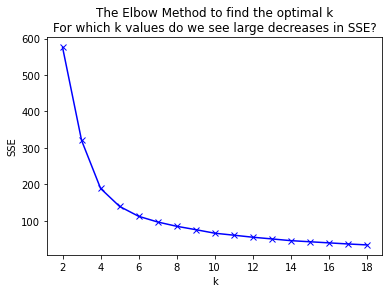

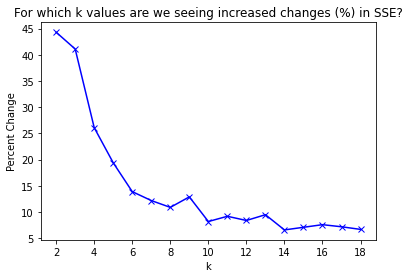

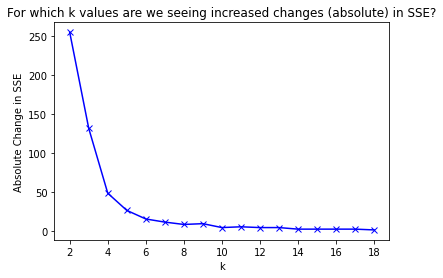

,k,sse,delta,pct_delta
0,2,576.065488,255.0,44.3
1,3,320.651552,132.0,41.1
2,4,188.728795,49.0,26.1
3,5,139.460467,27.0,19.4
4,6,112.418062,16.0,13.9
5,7,96.787548,12.0,12.2
6,8,85.015372,9.0,10.9
7,9,75.790072,10.0,12.9
8,10,66.038867,5.0,8.2
9,11,60.604231,6.0,9.2


In [22]:
find_k(X[0], cluster_vars, k_range)

In [23]:
k = 4
# as reminders: 
cluster_vars = ['scaled_acres', 'scaled_latitude']
cluster_name = 'size_cluster'

In [24]:
kmeans = create_clusters(X[0], k, cluster_vars)

In [25]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

In [26]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [50]:
acres = pd.DataFrame(X[0].groupby(['size_cluster','scaled_acres', 'scaled_latitude'])['size_cluster'].count())

Text(0.5, 1.0, 'Clusters of Properties by Latitide and Acres (scaled)')

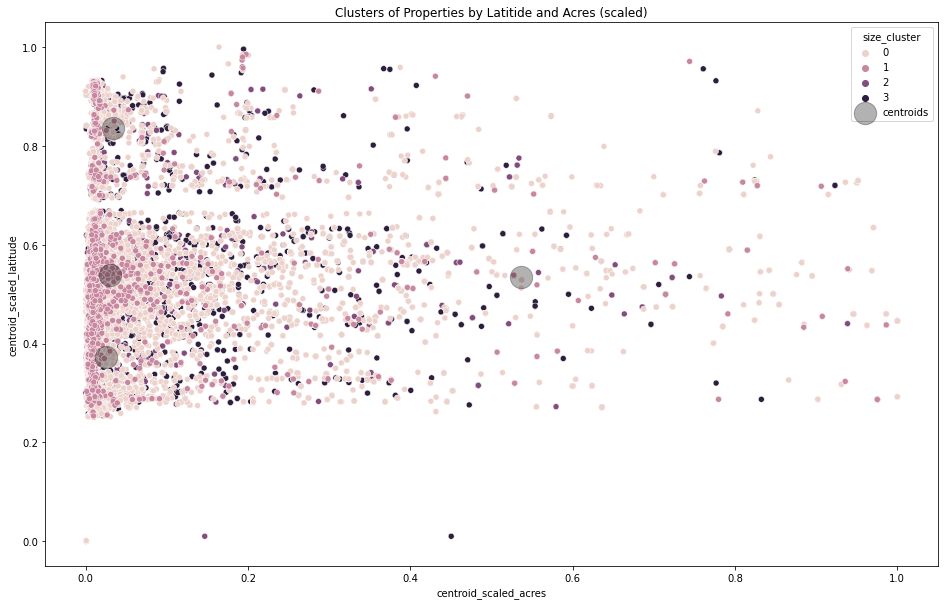

In [51]:
plt.figure(figsize=(16,10))

sns.scatterplot(x='scaled_acres', y='scaled_latitude', data=X[0], hue='size_cluster')

# plot cluster centers (centroids)
centroid_df.plot.scatter(x='centroid_scaled_acres', y='centroid_scaled_latitude', ax=plt.gca(), color='k', alpha = 0.3, s = 500, marker = 'o', label = 'centroids')

plt.title('Clusters of Properties by Latitide and Acres (scaled)')

In [52]:
centroid_df

,size_cluster,centroid_scaled_acres,centroid_scaled_latitude
0,0,0.030309,0.537718
1,1,0.536469,0.533667
2,2,0.033799,0.835753
3,3,0.025302,0.372719


In [53]:
acres

size_cluster
size_cluster scaled_acres scaled_latitude              
0            0.000000     0.911328                    1
             0.000034     0.910382                    1
             0.000086     0.489828                    1
             0.000107     0.464449                    1
             0.000347     0.001186                    1
...                                                 ...
3            0.975360     0.286683                    1
                          0.287126                    1
             0.986360     0.437639                    2
             0.999936     0.292091                    3
             1.000000     0.445819                    4

[23442 rows x 1 columns]

In [54]:
X[0]

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,...,scaled_regionidcity,scaled_regionidzip,scaled_structuretaxvaluedollarcnt,scaled_landtaxvaluedollarcnt,scaled_age,scaled_taxrate,scaled_acres,size_cluster,centroid_scaled_acres,centroid_scaled_latitude
12248933,2.0,4.0,8.0,1784.0,33.875127,-118.296637,6.037603e+07,45398.0,96104.0,59212.0,...,0.106616,0.804231,0.007869,0.002751,0.358779,0.238874,0.007412,3,0.025302,0.372719
11110824,1.0,2.0,6.0,834.0,34.450725,-118.498152,6.037920e+07,54311.0,96373.0,60400.0,...,0.129292,0.846700,0.008028,0.008068,0.297710,0.251918,0.263323,3,0.025302,0.372719
11115676,3.0,3.0,8.0,1320.0,34.435791,-118.558765,6.037920e+07,54311.0,96377.0,206386.0,...,0.129292,0.847332,0.027473,0.007150,0.091603,0.251468,0.045871,3,0.025302,0.372719
11059395,2.0,4.0,8.0,1916.0,34.256376,-118.495653,6.037111e+07,12447.0,96369.0,110195.0,...,0.022785,0.846069,0.014660,0.003530,0.435115,0.218948,0.011813,3,0.025302,0.372719
12363460,2.0,2.0,8.0,1817.0,33.976045,-118.211194,6.037533e+07,39076.0,96110.0,105808.0,...,0.090532,0.805178,0.014076,0.006942,0.526718,0.265137,0.008897,3,0.025302,0.372719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11818806,1.0,2.0,6.0,733.0,34.072700,-118.163000,6.037202e+07,12447.0,96013.0,80000.0,...,0.022785,0.789864,0.010638,0.009701,0.259542,0.209007,0.296935,1,0.536469,0.533667
11451402,2.0,2.0,8.0,1207.0,33.873400,-118.314000,6.037650e+07,54722.0,96162.0,155874.0,...,0.130337,0.813388,0.020744,0.003255,0.175573,0.206048,0.087092,1,0.536469,0.533667
12852173,2.0,3.0,6.0,1178.0,33.985379,-117.874727,6.037409e+07,22827.0,96492.0,93805.0,...,0.049193,0.865488,0.012477,0.010526,0.328244,0.219711,0.011340,1,0.536469,0.533667
11752192,2.0,3.0,6.0,1829.0,34.052119,-118.341295,6.037217e+07,12447.0,96000.0,32326.0,...,0.022785,0.787812,0.004288,0.014947,0.709924,0.210104,0.009168,1,0.536469,0.533667
